# Fitting thermal denaturation data

Based on Consalvi et al.,Protein Engineering, 2000 and [this](https://github.com/eloyvallinaes/protein-physics-2022/blob/67d116063917e8a6a1fa7965dc36d79ffe8608e0/logisticModel.ipynb) notebook for fitting a simple logistic model to chemical denaturation data.<br>

Here I show how to fit a sigmoidal denaturation curve, assuming a two-state equilibrium and the reversability of the process. For thermal denaturation the corresponding equation for the experimental signal S is given as, <p>

$$S = \frac{\text{intercept}_A + \text{slope}_A T + (\text{intercept}_B + \text{slope}_B T) \exp[{\frac{\Delta H} {R} (\frac{1}{T_m} - \frac{1}{T})}]} {1 + \exp[{\frac{\Delta H} {R} (\frac{1}{T_m} - \frac{1}{T})}]}.$$

With the standard reaction enthalpy $\Delta H$, midpoint temperature $T_m$, slopes of the baseline A and B and intercepts of the baseline A and B. For a detailed derivation have a look at e.g., Tim Sharpe, Biozentrum Basel 2012. Please note that the assumptions made here, often don't hold true when considering thermal denaturation of proteins and applying this model without proper consideration of the observed system can thus lead to misguiding results.


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np
import random

## Sample data

First we need to create some sample data. I do this by randomly creating a reasonable denaturation curve for thermal denatured as could be measured e.g., by CD or IR spectroscopy. 

In [2]:
def sample_data(seed = 9470):

    # Set a seed for reproducability
    random.seed(seed)
    np.random.seed(seed)
    
    t = np.linspace(293, 363, num=40)

    # generate random parameters for sigmoidal
    s_a = random.uniform(3,6)
    m_a = random.uniform(-0.005,0)
    s_b = random.uniform(3,6)
    m_b = random.uniform(-0.005,0)
    dH  = random.uniform(200000,400000)
    t_m = random.uniform(317,327)

    # generate the datapoints
    y = (s_a +m_a * t + (s_b + m_b * t)*np.exp(-dH * (1/t_m -1/t)/8.314)) / (1+np.exp(-dH * (1/t_m -1/t)/8.314))
    
    # add some random noise
    noise = np.random.normal(0, 0.15,len(y))

    return y+noise


Lets have a look what our sample data would look like. We can see our midpoint Temperature at around 52 °C and two slanted baselines.

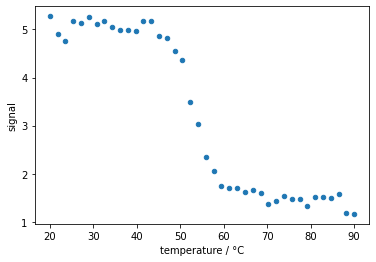

In [3]:
data = pd.DataFrame({'temperature / °C': np.linspace(20, 90, num=40),
                     'temperature / K':np.linspace(293.15, 363.15, num=40), 
                     'signal':sample_data()}) 

data.plot.scatter('temperature / °C','signal');

It might be helpful to normalize this data to represent a fraction rather than the raw signal.


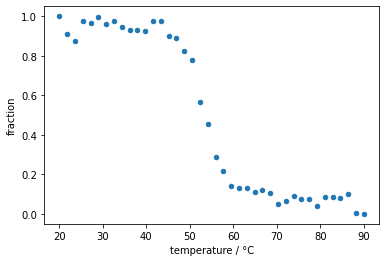

In [4]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
data['fraction'] = data[['signal']].apply(normalize)

data.plot.scatter('temperature / °C','fraction');

## Fitting
In order to fit the equation described above, we start by defining our model and a loss function. Here I use the residual difference between experimental observation and prediction.

In [5]:
def model(t, param):

    sa, ma, sb, mb, dH, tm = param
    
    return (sa +ma * t + (sb + mb * t)*np.exp(-dH * (1/tm -1/t)/8.314)) / (1+np.exp(-dH * (1/tm -1/t)/8.314))

def loss_function(param,x,y):
    # y - y_predicted
    return y - model(x,param)

We now have to define initial parameters as a starting point for the fitting. Here it is important to get as good as possible in order to achive convergance. This is going to determine the quality of our results.

In [6]:
# initial parameters
param = [ 3, -0.003, 4,  -0.003, 4e+05, 325]

# least squares optimizer
lsq = least_squares(loss_function, param, args=(data['temperature / K'], data['fraction']), verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.8607e+01                                    1.40e+04    
       1              2         1.6891e-02      7.86e+01       2.68e+04       1.72e+01    
       2              3         1.6205e-02      6.86e-04       1.60e+04       7.16e-01    
       3              4         1.6202e-02      2.44e-06       2.26e+03       8.66e-03    
       4              5         1.6202e-02      1.37e-09       1.40e+01       1.43e-06    
       5              6         1.6202e-02      1.08e-12       1.91e+00       1.06e-08    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 7.8607e+01, final cost 1.6202e-02, first-order optimality 1.06e-08.


In [7]:
# save the fit in the dataframe
data['fit'] = data['temperature / K'].apply(model,param = lsq.x)
print(f'final parameters: {[round(x,4) for x in list(lsq.x)]}')

final parameters: [0.9413, -0.0025, 0.992, -0.0001, 391478.274, 326.0435]


These final parameters can now be passed to our model so we can visualy examine the fit,

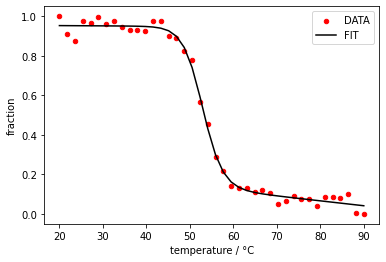

In [8]:
ax = data.plot.scatter('temperature / °C','fraction', color = 'red', label = 'DATA')
data.plot('temperature / °C', 'fit', color = 'k',label='FIT', ax=ax);

print(f"Midpoint temperature: {round(lsq.x[5],2)} K")
print(f"Enthalpy: {round(lsq.x[4],2)} J/mol")

## Now lets do it with your data!
Just add your fule name and make sure that column names match the ones used here (or change them in the notebook)

In [ ]:
# Add your file and fit your data
YOUR_FILENAME = 'data.csv'

# Load the data
try: 
    data = pd.read_csv(YOUR_FILENAME)
except:
    data = None
    print('No data file found')

if data:
    # Normalize the data
    data['fraction'] = data[['signal']].apply(normalize)

    # initial parameters
    param = [ 3, -0.003, 4,  -0.003, 4e+05, 325]

    # least squares optimizer
    lsq = least_squares(loss_function, param, args=(data['temperature / K'], data['fraction']), verbose=2)

    # save the fit in the dataframe
    data['fit'] = data['temperature / K'].apply(model,param = lsq.x)

    # Plot the data and the fit
    ax = data.plot.scatter('temperature / °C','fraction', color = 'red', label = 'DATA')
    data.plot('temperature / °C', 'fit', color = 'k',label='FIT', ax=ax);

    # Print the enthalpy and midpoint temperature
    print(f'Enthalpy: {lsq.x[4]} J/mol')
    print(f'Midpoint temperature: {lsq.x[5]} K')